<a href="https://colab.research.google.com/github/Thaboe-dev/Sentiment-Analysis---BERT/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 33.5 MB/s 
     |████████████████████████████████| 596 kB 60.6 MB/s 
     |████████████████████████████████| 101 kB 10.0 MB/s 
     |████████████████████████████████| 6.6 MB 65.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Training the Model

In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [13]:
import tensorflow as tf
import pandas as pd

In [ ]:
#Downloading the IMDB dataset
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84140032/84125825 [==============================] - 4s 0us/step


In [ ]:
#Removing unlabelled reviews
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['urls_neg.txt', 'urls_unsup.txt', 'labeledBow.feat', 'neg', 'urls_pos.txt', 'pos', 'unsupBow.feat']


In [ ]:
#Creating a dataset and Splitting the data
# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
#Viewing and preprocessing
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [ ]:
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [ ]:
#Creating Input Sequences
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
#Data Preprocessing
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#Configuring the BERT model and Fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
1250/1250 [==============================] - 1119s 876ms/step - loss: 0.2693 - accuracy: 0.8855 - val_loss: 0.3280 - val_accuracy: 0.8680
Epoch 2/2
1250/1250 [==============================] - 1088s 871ms/step - loss: 0.0742 - accuracy: 0.9742 - val_loss: 0.4980 - val_accuracy: 0.8790


In [ ]:
#Defining a Predictions Function
def predict(sentence):
  tf_batch = tokenizer(sentence, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  labels = ['Negative','Positive']
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()
  for i in range(len(sentence)):
    print(sentence[i], ": \n", labels[label[i]])

In [64]:
#Making Predictions
review = ["Would be great if their commitment to sustainability involved not trying to get people to buy a brand new phone every year... or only making the batteries replaceable after they came under major fire for their irreplaceability A company can apparently only care so much about sustainability when their entire purpose is to make money"]
#predict(review)

Using a PreTrained Model

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
new_model = TFBertForSequenceClassification.from_pretrained('/content/gdrive/My Drive/Colab Notebooks/mymodel')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/gdrive/My Drive/Colab Notebooks/mymodel.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [65]:
#Method for Prediction
def predict2(sentence):
  tf_batch = tokenizer(sentence, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = new_model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  labels = ['Negative','Positive']
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()
  
  return labels[label[0]]

predict2(review)

'Negative'

Scraping Movie Reviews from IMDB

In [7]:
#importing libraries
import requests
from bs4 import BeautifulSoup

In [8]:
# --Retrieve website data
url = 'https://www.imdb.com/title/tt9419884/reviews?ref_=ttexrv_ql_3'
response = requests.get(url)
page = BeautifulSoup(response.content)
response

<Response [200]>

In [9]:
review_tiles = page.findAll('div', attrs={'class':'review-container'})
len(review_tiles)

25

In [ ]:
review_tiles

In [59]:
# --Empty lists for dataframe
ratings = []
titles = []
reviews = []
predictions = []


# --Isolating the relevant sections
for i in range(len(review_tiles)):
  first_review = review_tiles[i]

  # -rating
  rating = first_review.find('div',attrs = {'class':'ipl-ratings-bar'}).find('span'
  ,attrs={'class':'rating-other-user-rating'}).find('span').text
  #print(f'Rating :{rating}')

  # -review title
  title = first_review.find('a',attrs = {'class':'title'}).text
  #print(f'Review Title :{title}')

  # -review
  review = first_review.find('div',attrs = {'class':'content'}).find('div',attrs =
        {'class':'text show-more__control'}).text.replace(',','').replace('.','\n')
  '''print(f'Review :{review}')
  print('--'*50)
  print()'''


  #Appending Web data into the lists
  ratings.append(rating)
  titles.append(title)
  reviews.append(review)

In [60]:
# --making a Dataframe from the scraped data
df = pd.DataFrame({
    'Rating Score/10':ratings,
    'Review Title':titles,
    'Review':reviews
})
df.head()

,Rating Score/10,Review Title,Review
0,7,"This was Wandavision 2, not Doctor Strange 2\n",I liked this movie and I think it's a fine add...
1,5,"Well, it was shiny and colourful\n",So carrying on from WandaVision Wanda continue...
2,6,Not enough multiverse and maybe too much madn...,Sam Raimi definitely put a splash of horror in...
3,2,"Scarlet Witch: The Movie, ft: Sorcerer Suprem...",Great visuals actors and actresses do their be...
4,4,"Terrible plot and script, boring and pointless\n",I always had some issues with MCU films but no...


Making Predictions on the Dataframe

In [66]:
# -Cleaning the input data
import string
df['Review'] = df['Review'].str.translate(str.maketrans('', '', string.punctuation))

# -Predictions
for review in df.Review.values.tolist():
  predictions.append(predict2(review))

df['Sentiment'] = predictions


In [69]:
df.head()

,Rating Score/10,Review Title,Review,Sentiment
0,7,"This was Wandavision 2, not Doctor Strange 2\n",I liked this movie and I think its a fine addi...,Positive
1,5,"Well, it was shiny and colourful\n",So carrying on from WandaVision Wanda continue...,Positive
2,6,Not enough multiverse and maybe too much madn...,Sam Raimi definitely put a splash of horror in...,Positive
3,2,"Scarlet Witch: The Movie, ft: Sorcerer Suprem...",Great visuals actors and actresses do their be...,Positive
4,4,"Terrible plot and script, boring and pointless\n",I always had some issues with MCU films but no...,Negative


In [70]:
df.tail()

,Rating Score/10,Review Title,Review,Sentiment
20,1,Terrible\n,This was by far the worst marvel so far\n The ...,Negative
21,8,Massively improves on a second viewing\n,I was not in a good head space at all watching...,Negative
22,6,A Puzzle No One Cares To Solve\n,Oh director Sam Raimi is up to his Army Of Dar...,Negative
23,2,One of the worst superhero movies out there\n,Dr\n Strange here was absolutely weak and crin...,Negative
24,3,Utterly disappointed\n,Im a self confessed marvel nut but I found thi...,Negative


Data Visualization

In [71]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn

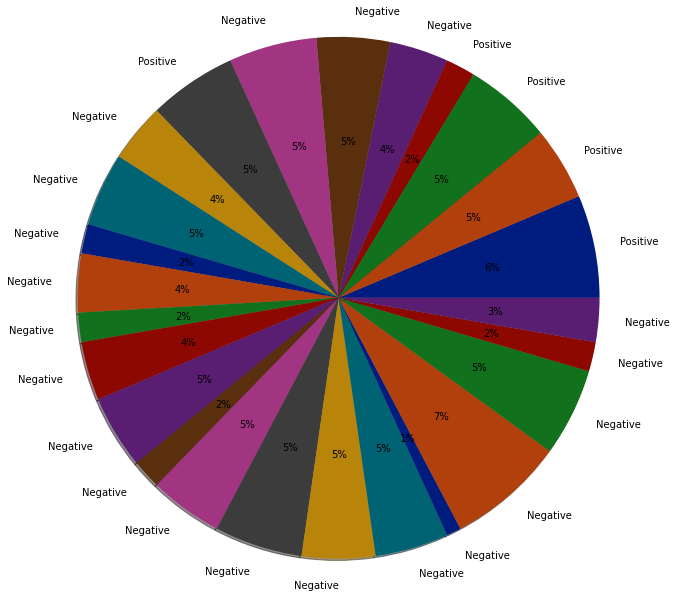

In [77]:
# declaring data
data = df['Rating Score/10']
keys = df['Sentiment']
  
# declaring exploding pie
explode = [0, 0.1, 0, 0, 0]
# define Seaborn color palette to use
palette_color = seaborn.color_palette('dark')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        autopct='%.0f%%',shadow=True,radius=3)
  
# displaying chart
plt.show()

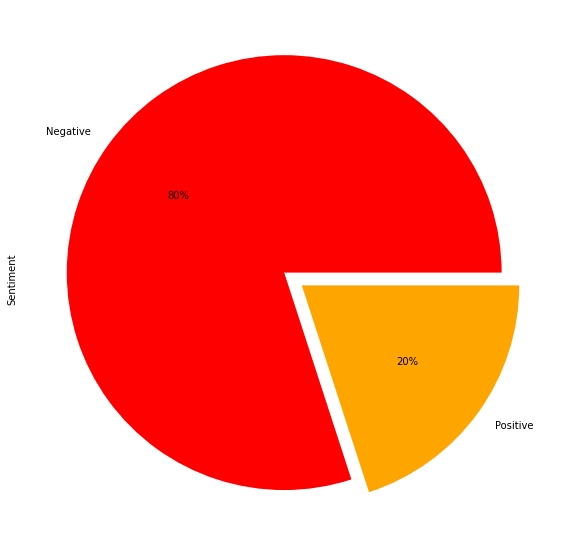

In [87]:
# Defining colors for the pie chart
colors = ['red', 'orange']
  
# Define the ratio of gap of each fragment in a tuple
explode = (0.05, 0.05)
  
# Plotting the pie chart for above dataframe
df['Sentiment'].value_counts().plot(
    kind='pie', y=df['Sentiment'],  autopct='%1.0f%%',
  colors=colors, explode=explode ,figsize=(10,10))